In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np
import gensim.downloader
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, KeyedVectors
import re

In [2]:
#Dowload our df and pick features,that we are going to work
df = pd.read_csv('D:/boardgame/games_detailed_info.csv')
df = df.drop(columns=['type','id','thumbnail','image','primary',
                      'alternate','War Game Rank','Customizable Rank'
                      ,'Children\'s Game Rank','RPG Item Rank',
                      'Accessory Rank','Video Game Rank','Amiga Rank',
                      'Commodore 64 Rank','Arcade Rank','Atari ST Rank',
                     'suggested_num_players','suggested_playerage',
                     'suggested_language_dependence','wanting','wishing',
                     'numcomments','numweights','averageweight','boardgameintegration'
                     ,'boardgamecompilation','Party Game Rank','Abstract Game Rank',
                     'Thematic Rank','Unnamed: 0','bayesaverage','Board Game Rank',
                     'Strategy Game Rank','Strategy Game Rank','Family Game Rank'
                     ,'stddev','median','owned','trading','boardgamefamily',
                      'boardgameexpansion','boardgameimplementation','usersrated',
                     'maxplayers','playingtime','minplaytime','maxplaytime'])

#fillNA
df.boardgamecategory= df.boardgamecategory.fillna('Game')
df.boardgamemechanic= df.boardgamemechanic.fillna('Game')
df.boardgamedesigner= df.boardgamedesigner.fillna('[\'(Uncredited)\']') 
df.boardgameartist= df.boardgameartist.fillna('[\'(Uncredited)\']') 
df.boardgamepublisher =df.boardgamepublisher.fillna('[\'(Uncredited)\']') 
df.yearpublished= df.yearpublished.fillna('1950')


In [3]:
#work with 7 strong group,other to group 1,because of simular answer 
temp=[2,1,3,4,5,0,6]
df.minplayers=df.apply(lambda x:x.minplayers if x.minplayers in temp else 1,axis=1)
df = pd.get_dummies(df,columns=['minplayers'],drop_first=True)

#work with 18 strong group
temp=[12,8,10,14,0,13,6,7,5,9,4,18,16,15,3,11,17,2]
df.minage=df.apply(lambda x:x.minage if x.minage in temp else 1,axis=1)
df = pd.get_dummies(df,columns=['minage'],drop_first=True)

In [ ]:
df.minplayers.value_counts()
temp=[2,1,3,4]
df.minplayers=df.apply(lambda x:x.minplayers if x.minplayers in temp else 1,axis=1)
ax=sns.barplot(x='minplayers',y='average',data=df)
#We have 4 strong group and deside to distribute other small group to group with min.players 1,becouse aver.is the simular
temp=df.yearpublished.value_counts()

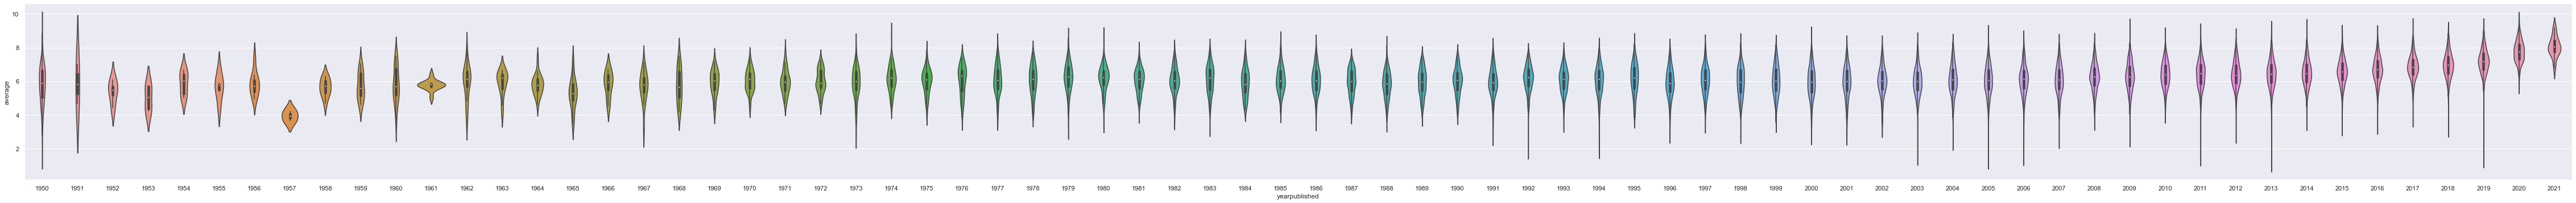

In [9]:
df.yearpublished.value_counts()
temp=df.loc[:,['yearpublished','average']]
cr=df.yearpublished.value_counts()
df.yearpublished=df.apply(lambda x:x.yearpublished if int(x.yearpublished)>1950 else 1950,axis=1)
sns.set(rc={'figure.figsize':(80.27,5.7)})
a=sns.violinplot(data=df, x="yearpublished", y="average")
had=df.yearpublished.value_counts()

In [6]:
#Make vocab to our WtV model
def string_to_word(c):
    c=str(c)
    if c.isalpha() or c.isspace():
        return c.lower()
    elif c=='.' or c==',' or c=='?' or c=='!':
        return ' '
    return ''

#Make vector of word
def to_vec(c):
    global count
    result=np.zeros(100)
    _=re.findall(r'\b\S+\b',c)
    for i,elem in enumerate(_):  
        elem = re.sub('[\'!@#/\$]', '', elem)
        elem=elem.lower()
        try:
            _[i]=main_model.wv[elem]
            if i!=0:
                result+=_[i]+_[i-1]
        except:
            result+=np.zeros(100)
    list_of_vector.append(result)
    return c

#Make name of artis and etc to classes. 
def list_of(row):
    global dict_name
    global count_name
    name_list = []
    result = ''
    row = row.replace('\'', '')
    row = row.replace('[', '')
    row = row.replace(']', '')
    row = row.replace(' ', '')
    row = row.split(',')
    for elem in row:
        if elem in dict_name:
            name_list.append(dict_name[elem])
        else:
            dict_name[elem] = count_name
            name_list.append(count_name)
            count_name += 1

    result = ','.join(str(i) for i in name_list)
    return result

In [7]:
#We use description to fit our pretrained WTV model
a=df.description.tolist()
result=['']
for elem in a:
    temp=''
    elem=str(elem)
    temp+=''.join(string_to_word(c) for c in elem )
    result.append(temp.split(' '))

In [8]:
#size,lockf - moment to tune
#i use pretrained model with Wikipedia vocab
model = KeyedVectors.load_word2vec_format("D:/wordtovec/glove.6B.100d.txt", binary=False)
main_model = Word2Vec(result,size=100,min_count=1)
main_model.build_vocab([list(model.vocab.keys())],update=True)
main_model.intersect_word2vec_format("D:/wordtovec/glove.6B.100d.txt", binary=False, lockf=0.6)
total_examples = main_model.corpus_count
main_model.train(result, total_examples=total_examples, epochs=2)


(7173244, 8016976)

In [9]:
#Work with boardgamecategory
list_of_vector=[]
df.boardgamecategory = df.apply(lambda x:to_vec(x.boardgamecategory),axis=1)
vector_df=pd.DataFrame(list_of_vector)
df=df.merge(vector_df,left_index=True,right_index=True)

In [10]:
#Work with boardgamemechanic
list_of_vector=[]
df.boardgamecategory = df.apply(lambda x:to_vec(x.boardgamemechanic),axis=1)
vector_df=pd.DataFrame(list_of_vector)
df=df.merge(vector_df,left_index=True,right_index=True)

In [11]:
#Work with boardgamedesigner
count_name=0
dict_name={}
df.boardgamedesigner = df.apply(lambda x:list_of(x.boardgamedesigner),axis=1)
temp=df['boardgamedesigner'].str.get_dummies(sep=',')
#sum>10 This is First moment to tune , if overfitt . 35 is number,when we will have 50 columns
temp= temp.iloc[:, list(temp.sum(axis=0)>17)]           
df=df.merge(temp,left_index=True,right_index=True)

In [12]:
#Work with boardgamedartist
count_name=0
dict_name={}
df.boardgameartist  = df.apply(lambda x:list_of(x.boardgameartist),axis=1)
temp=df['boardgameartist'].str.get_dummies(sep=',')
#sum>10 This is First moment to tune , if overfitt . 35 is number,when we will have 50 columns
temp= temp.iloc[:, list(temp.sum(axis=0)>16)]           
df=df.merge(temp,left_index=True,right_index=True)

In [13]:
#Work with boardgamepublisher
count_name=0
dict_name={}
df.boardgamepublisher  = df.apply(lambda x:list_of(x.boardgamepublisher),axis=1)
temp=df['boardgamepublisher'].str.get_dummies(sep=',')
#sum>10 This is First moment to tune , if overfitt .149 is number,when we will have 50 columns
temp= temp.iloc[:, list(temp.sum(axis=0)>40)] 
df=df.merge(temp,left_index=True,right_index=True)

In [14]:
df=df.drop(columns=['description','boardgamecategory','boardgamemechanic','boardgamedesigner','boardgameartist','boardgamepublisher','yearpublished'],axis=1)

In [31]:
from sklearn.model_selection import train_test_split
X, y = df.drop('average', axis=1), df['average']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X_train

array([[-0.42525435,  0.65605218, -0.36481876, ..., -0.04775227,
        -0.05294286, -0.06257337],
       [-0.42525435, -1.524269  ,  2.74108708, ..., -0.04775227,
        -0.05294286, -0.06257337],
       [-0.42525435,  0.65605218, -0.36481876, ..., -0.04775227,
        -0.05294286, -0.06257337],
       ...,
       [-0.42525435, -1.524269  ,  2.74108708, ..., -0.04775227,
        -0.05294286, -0.06257337],
       [-0.42525435, -1.524269  ,  2.74108708, ..., -0.04775227,
        -0.05294286, -0.06257337],
       [-0.42525435, -1.524269  ,  2.74108708, ..., -0.04775227,
        -0.05294286, -0.06257337]])

In [33]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
# scorer = make_scorer(mean_squared_error,greater_is_better=False)
# params={
#     "CV" : [0.01,0.1,1,10,100]
#      "gamma": [0.00,0.0001,0.001,0.01,0.1,1,10,100,1000]
#         }
#model=GridSearchCV(model_base,params,scoring=scorer,cv=2,verbose=3)
#use best params
model = SVR(C=10,gamma=0.0001)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [40]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred, squared=False))   #On test
print(mean_squared_error(y_train, y_pred_train, squared=False)) # On train
#model.coef_

0.668643933873207
0.6316370101334543


<AxesSubplot:xlabel='average', ylabel='Count'>

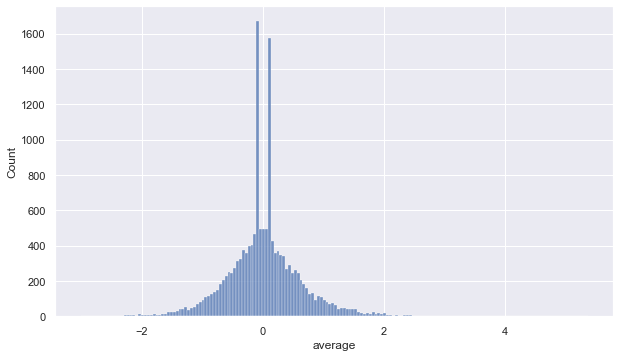

In [41]:
sns.set(rc={'figure.figsize':(10.0,5.7)})
sns.histplot(y_pred_train - y_train)
#We have simular to Normal distribution(with two outliiers),that why we have optimal model with our number of features